# SIIM-ISIC Competition Submission
## Authors - Sarthak Khandelwal, Sergei Issaev

# Table of Contents

* [Introduction](#1)
* [Import Required Libraries](#2)
* [Configration](#3)
* [Load the Data](#4)
* [Utility Functions](#5)
    * [Decoding the Data](#5)
    * [Convert TfRecord to tf.Example](#6)
    * [Preparing Dataset](#7)
    * [Data Augmentation](#8)
    * [Define Dataset](#9) 
    * [Get Images Count](#10)
    * [Build Model](#11)
        * [Define Learning Rate](#11)
        * [Build Base Model](#12)
* [Load Dataset](#13)
* [Class Imbalance](#14)
* [Train Model](#15)
* [Visualize Scores](#16)
* [Make Submission](#17)

# 1) Introduction <a id="1"></a>

Basically this problem is about image classification where we have to find the probability of a patient having `Melanoma` given images of his `skin lesions`. This is accomplished by classifying the sample as malignant. One thing to note here is that we don't have to predict the classes but the probabilty of positive class (malignant) and hence we won't have to apply any thresholds here. Just return score calculated by model.<br>

What you will learn in this notebook: <br>
- EfficientNet - A family of image classification models which acheive state-of-the-art accuracy.
- How to Work with TPU.
- Transfer Learning
- Working with tensorflow input pipelines.
- How to handle data in `tfrecord` format.
- How to deal with Class Imbalance.

**Please let me know in the Comments about what you learnt from the notebook that is not in the above list :)**

In [ ]:
# Installing EfficientNet module 
!pip install efficientnet

## Import Required Libraries <a id="2"></a>
To enable training with TPU's we need to configure them first.

Here's what each line of its configration works:
- `TPUClusterResolver` : Locates the cluster on the network
- `experimental_connect_to_cluster`: Will make devices on the cluster available to use
- `initialize_tpu_system`: Initialize the TPU devices.
- `TPUStrategy`:  Contains necessary distributed training code that will work on TPUs with their 8 compute cores 

In [ ]:
# Computation Specific
import re
import os
import numpy as np
import pandas as pd
from functools import partial

# Machine Learning Specific
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import CSVLogger


# Augmentation and Visualization Specific
import imgaug
import matplotlib.pyplot as plt

# Pretrained Model
import efficientnet.tfkeras as efn


TPU_used = True
if TPU_used:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Device:', tpu.master())
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    except:
        strategy = tf.distribute.get_strategy()
    print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

# 2) Configration <a id="3"></a>
Lets define some configrations used throughout the notebook.
- `AUTOTUNE` : Tune values dynamically at runtime.
- `GCS_PATH` : Get the Corresponding Google Cloud Storage path where this dataset is hosted.
- `BATCH_SIZE`: Set batch size for the model.
- `IMAGE_SIZE` : Set the shape of the images which are used throughout the notebook.<br>

**Because TPUs are very fast, many models ported to TPU end up with a data bottleneck. And hence its a good practice to read data from GCS (Google Cloud Storage). TPUs read training data exclusively from GCS.**

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
IMAGE_SIZE = [1024, 1024]

# 3) Load the data <a id="4"></a>
Now we will load in our data. For this notebook, we will be importing the TFRecord Files.
- `glob` would return a list of filenames matching a certain pattern provided to it.

In [ ]:
TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(
    tf.io.gfile.glob(GCS_PATH + '/tfrecords/train*.tfrec'),
    test_size=0.2, random_state=42
)
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/test*.tfrec')
print('Train TFRecord Files:', len(TRAINING_FILENAMES))
print('Validation TFRecord Files:', len(VALID_FILENAMES))
print('Test TFRecord Files:', len(TEST_FILENAMES))

# 4) Utility Functions <a id="5"></a>

## 4.1 Decoding the data

- Tensorflow model needs data to be Tensors or numpy arrays for training. <br>

- Here we are using `tf.image.decode_jpeg` to decode the image into JPEG format and as this would be an RGB image, we kept number of channels to be 3.<br>

- We would also normalize the images such that pixel values would now range from `[0,1]` instead of `[0,255]`.
<br>

In [ ]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

As we load in our data, we need both our ```X``` and our ```Y```. The X is our image; the model will find features and patterns in our image dataset. We want to predict Y, the probability that the lesion in the image is malignant. When we input our training dataset into the model, it is necessary know what the labels of our images are. For our testing set, we do not need to feed in the labels because the model will predict it for us. In this particular dataset, our label is the ```target``` feature. We will to through our TFRecords and parse out the image and the target values.

## 4.2 Convert  TfRecord to tf.Example <a id="6"></a>
- The Below Function is used to convert the `.tfrecord` file into `tf.Example`. This gives us features and labels of our dataset, feature being the image and label being the class-id (0 or 1) for benign or malignant. <br>
- As we know that we would not be needing labels for our test set and hence we would have two formats that data resides in our `.tfrecord` files namely labelled and unlabelled data. Unlabelled is used for testing and its format also would be different and hence we are toggling between different formats based on whether the given image is labelled or not. 

In [ ]:
def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

## 4.3 Prepare Dataset <a id="7"></a>
- Our dataset is not ordered in any meaningful way, so the order can be ignored when loading our dataset for training. By ignoring the order and reading files as soon as they come in, it will take a shorter time to load the data.
- Note that the above function `read_tfrecord` is called from `load_dataset` to parse `TfRecord Dataset` to get `tf.Example` object.

In [ ]:
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    dataset = tf.data.TFRecordDataset(filenames,num_parallel_reads=AUTOTUNE) 
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled),num_parallel_calls=AUTOTUNE)
    if not ordered:
        ignore_order.experimental_deterministic = False 
        dataset.with_options(ignore_order)
    return dataset

 ## 4.4 Data augmentation<a id="8"></a>

Image augmentation introduces new images into our data, and generally prevents the model from overfitting and leads to higher accuracy on testing datasets. We will perform following augmentations in the dataset.

- `tf.image.random_flip_left_right`: Randomly flips the image either to left or right.
- `tf.image.random_saturation`: Adds random saturation to image. Sometimes beneficial if image is deem or fade.
- `tf.image.random_brightness`: Adds random brightness to the image.
- `tf.image.random_flip_up_down`: Randomly flips the image either to up or down.

In [ ]:
def augmentation_pipeline(image,label):
    image = tf.image.convert_image_dtype(image,tf.float32)
    image  =tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image,max_delta=0.5)    
    return image,label

#image = tf.image.random_brightness(image,max_delta=0.3)
#image = tf.image.random_flip_left_right(image)
#image  =tf.image.random_flip_up_down(image)
#image = tf.image.random_saturation(image,3,8)

## 4.5 Define Dataset
<a id="9"></a>
We define a class named `Dataset` through which we would be getting different datasets for `training`, `validation` and `testing`. <br>
Here we have implemented a function named `get_dataset` within this class which returns dataset for one of the given mode [`train`,`valid`,`test`].

- Note that most of data preprocessing steps are same for all the three modes. We have also seperated the ones which are specific to a particular mode. 

In [ ]:
class Dataset():
    
    def __init__(self,batch_size):
        self.batch_size = batch_size
    
    def get_dataset(self,filenames,labeled,ordered,mode="train"):
        
        assert(mode in ["train","valid","test"])    # Checking if the mode is one of the correct ones.
        
        # Prepairing dataset according to the provided mode.
        
        dataset = load_dataset(filenames, labeled=labeled,ordered=ordered)
        if mode=="train":
            dataset = dataset.map(augmentation_pipeline)
            dataset = dataset.repeat()
            dataset = dataset.shuffle(2048)
        
        dataset = dataset.batch(self.batch_size)
        dataset = dataset.prefetch(AUTOTUNE)
                                                    
        if mode=="valid":
            dataset = dataset.cache()
            
        return dataset
    

## 4.6 Get total number of Train, Validation and Test images.<a id="10"></a>
Below functions uses a python module named `re` to count the number of images from the given list of Images. <br>
For more details on `re` or `Regular Expressions` refer [this](https://docs.python.org/3/library/re.html).

In [ ]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)


NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print(
    'Dataset: {} training images, {} validation images, {} unlabeled test images and the steps per epoch is {}'.format(
        NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES, STEPS_PER_EPOCH
    )
)

## 4.7 Build the Model
<a id="11"></a>
- **The following set of utility functions would help us building our model for the given task.**

## 4.7.1 Define Learning Rate

The following function allows for the model to change the learning rate as it runs each epoch. Having a learning rate that is too high will prevent our model from converging. However, having a learning rate that is too small will cause our model to run for far too long. With this function, the model will know how to change its learning rate after each epoch and update the learning rate itself to allow for increased efficiency while still allowing the model to converge.

**We will define two approaches to which changes learning rate dynamically. First we should understand what they are.**

### #1. Time based
This method deals with reducing the learning rate over time. <br> 
For example consider we reduce learning rate as epochs increases by the rule -<br>
  
  &nbsp;&nbsp;  **learning_rate = learning_rate / (1 + decay * epoch )** <br>
  
Let the initial Learning-rate is `0.1` and decay be `0.001` LR at first five epochs are: <br>

epoch-1 = 0.1<br>
epoch-2 = 0.0999000999<br>
epoch-3 = 0.0997006985<br>
epoch-4 = 0.09940249103<br>
epoch-5 = 0.09900646517<br>


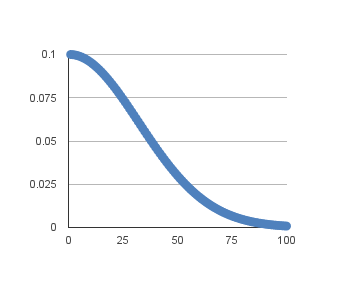
Example taken from [here](https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/). 


By looking above graph we can say that Learning Rate changes continuously in Time Based Approach of Schedulling Learning Rate.

In [ ]:
# Note that learning rate first increase till 10 epochs and then reduces as the epoch increases.
def build_lrfn(lr_start=0.00001, lr_max=0.000075, lr_min=0.0000001, lr_rampup_epochs=5, lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync
    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

## #2. Drop Based

In this approach we change learning rate conditionally. This function introduces discontinuous graph.<br>

For example if we decrease the learning rate in interval of 10 epochs and considering 100 epochs in total we would get the following graph. Also the learning rate is `0.1` intially.

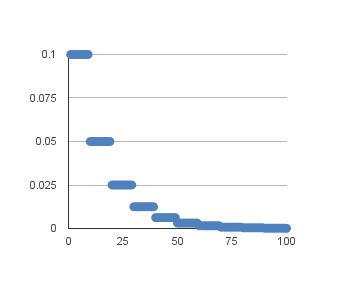
Example taken from [here](https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/). 

In [ ]:
def Callbacks():
    cb = []
    
    # Drop based LR Scheduling.
    reducelr = ReduceLROnPlateau(monitor="val_loss", mode="min", patience=5, min_lr = 1e-06, factor=0.2)
    log = CSVLogger("Melanoma_classification.csv")
    cb.append(reducelr)
    cb.append(log)
    return cb

## 4.7.2 Build base model
<a id="12"></a>
Here we will use `EfficientNetB0` pretrained model with custom architecture on the top. <br>
What we have just done is called `Transfer Learning`. For more info on transfer learning we recommend [this](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a) article.

In [ ]:
def make_model(output_bias = None, metrics = None):
    
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    base_model = efn.EfficientNetB7(input_shape=(*IMAGE_SIZE, 3),
                                             include_top=False,
                                             weights="imagenet")
    
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(32,activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16,activation="relu"),
        tf.keras.layers.Dense(8,activation="relu"),
        tf.keras.layers.Dense(1, activation='sigmoid',
                              bias_initializer=output_bias
                             )
    ])
    
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
                                                  0.001,
                                                  decay_steps=(NUM_TRAINING_IMAGES // BATCH_SIZE)*100,
                                                  decay_rate=1,
                                                  staircase=False
                                                )

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss='binary_crossentropy',
                  metrics=[metrics])
    
    return model

# 5) Load Dataset<a id="13"></a>
- **Now we will load the training as well as validation dataset.**

In [ ]:
dataset = Dataset(BATCH_SIZE)
train_dataset = dataset.get_dataset(TRAINING_FILENAMES,labeled = True,ordered = False,mode="train")
valid_dataset = dataset.get_dataset(VALID_FILENAMES,labeled = True,ordered = False,mode="valid")

# 6) Checking for Class Imbalance and correcting it
<a id="14"></a>
Let's have a look at our dataset to see if it has class Imbalance or not.
- What is Class Imbalance though? 
<pre class="tab">Basically it is when the ratio between number of samples between classes is either too large or too   small. </pre>

In [ ]:
train_csv = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
test_csv = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')

total_img = train_csv['target'].size

malignant = np.count_nonzero(train_csv['target'])
benign = total_img - malignant

print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total_img, malignant, 100 * malignant / total_img))

- **As you can see that 1.76% of malignant samples out of 100% data we have. This clearly is a sign of class imbalanace.** <br>

- **We would correct it by setting initial bias and class weights for the model.**

## 6.1 Set initial bias

We want to set the correct initial bias for our model so that it will not waste time figuring out that there are not many malignant images in our dataset. We want our output layer to reflect the inbalance that we have in our data.

The correct bias to set can be derived from:
<pre class="tab">p0 = pos/(pos+neg) = 1/(1+ e<sup>-b0</sup>)
b0 = -log(1/p0 -1)
b0 = log(pos/neg)</pre>

In [ ]:
initial_bias = np.log([malignant/benign])
initial_bias

## 6.2 Set class weights

Since there are not enough malignant images, we want these malignant images to have more weight in our model. By increasing the weight of these malignant images, the model will pay more attention to them, and this will help balance out the difference in quantity.

In [ ]:
weight_for_0 = (1 / benign)*(total_img)/2.0 
weight_for_1 = (1 / malignant)*(total_img)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

- **Define learning rate and other configrations for model training.**

In [ ]:
lrfn = build_lrfn()
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

# 7) Start Training
<a id="15"></a>
Here we would take `AUC (Area Under the Curve)` as evaluation metric for our model becuase if the model would have `accuracy` as evaluation metric then it would give false confidence on the model.With predicting all examples as `benign (0)` the model could get **98%** accuracy which is false.
Moreover the competition scores the model by finding the area under the ROC curve, which is also why our metric will be set to `AUC`.

In [ ]:
with strategy.scope():
    model = make_model(metrics=tf.keras.metrics.AUC(name='auc'),output_bias=initial_bias)

In [ ]:
callback = Callbacks()

history = model.fit(
    train_dataset, epochs=20,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset,
    validation_steps=VALID_STEPS,
    callbacks= [tf.keras.callbacks.CSVLogger("Melanoma_classification.csv")],
    class_weight=class_weight,
    verbose=1
)
# tf.keras.callbacks.LearningRateScheduler(lrfn)
# tf.keras.callbacks.CSVLogger("Melanoma_classification_new.csv")

# 8) Visualize Scores
<a id="16"></a>
- **In the following function we would visualize AUC score and loss of the model for both training and validation mode.** 

In [ ]:
## Visualizing Model Performance
def visualize(epochs,x,y,label=""):
    plt.plot(epochs,x,marker="o",c="red",label=f"Training {label}")
    plt.plot(epochs,y,marker="x",c="green",label=f"Validation {label}")
    plt.legend()
    plt.grid(False)

visualize_df = pd.read_csv("/kaggle/working/Melanoma_classification.csv")
epochs       = visualize_df["epoch"]
auc          = visualize_df["auc"]
val_auc      = visualize_df["val_auc"]
loss         = visualize_df["loss"]
val_loss     = visualize_df["val_loss"]

fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
visualize(epochs,auc,val_auc,label="AUC")
plt.subplot(1,2,2)
visualize(epochs,loss,val_loss,label="LOSS")
plt.tight_layout()
plt.show()

# 9) Making Submission
<a id="17"></a>
- **Let's make a submission file for our Test Dataset by predicting the correct classes for samples in Test Dataset.**

In [ ]:
# Getting test Dataset.
# Note that here test dataset is ordered. 
test_ds = dataset.get_dataset(TEST_FILENAMES,labeled=False,ordered=True,mode="test")

In [ ]:
%%time
def submit(filename="submission.csv"):
    print('Generating submission.csv file...')
    print('Computing predictions...')
    test_images_ds = test_ds.map(lambda image, idnum: image)
    probabilities = model.predict(test_images_ds)
    repr("Prediction done")
    test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
    test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')
    pred_df = pd.DataFrame({'image_name': test_ids, 'target': np.concatenate(probabilities)})
    sub = pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv")
    del sub['target']
    sub = sub.merge(pred_df, on='image_name')
    sub.to_csv(open(filename,"w"), index=False)
    print("Submitted Successfully.....")

In [ ]:
submit()

## Thanks For Reading :)